# Implementering af Shor-fejlretningskoden, der kan korrigere både bitflip- og phase-flip-fejl og dermed også tilfældige fejl

1) Shor-koden bruger ni qubits til kodningen af qubitten, vi ønsker at beskytte, så vi skal bruge ni qubits i vores kredsløb plus otte qubits til identificering af fejlsyndromer. De kodede qubits inddeles i tre blokke af tre qubits (p, q og r nedenfor). Til hver blok er knyttet to fejlretningsqubits, og så er der yderligere to fejlretningsqubits til sidst. Alle qubits starter i tilstanden $\ket{0}$ undtagen den qubit, vi koder, som kan starte i enhver tilstand. Qubitten, vi koder, er p<sub>0</sub> nedenfor.

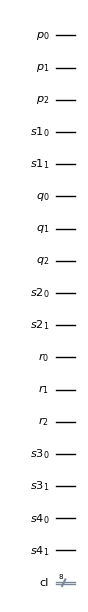

In [133]:
from qiskit import QuantumCircuit
from qiskit import QuantumRegister
from qiskit import ClassicalRegister

p, q, r, s1, s2, s3, s4 = QuantumRegister(3, "p"), QuantumRegister(3, "q"), QuantumRegister(3, "r"), QuantumRegister(2, "s1"), QuantumRegister(2, "s2"), QuantumRegister(2, "s3"), QuantumRegister(2, "s4")
cl = ClassicalRegister(8, "cl")
qc = QuantumCircuit(p, s1, q, s2, r, s3, s4, cl)

qc.draw("mpl", scale = 0.5)

2) Shor-koden inddeles i en "ydre kode" og en "indre kode". Den ydre kode svarer til phase-flip-fejlretningskoden, som er gennemgået i en anden notebook. Denne kode bruges på p<sub>0</sub>, q<sub>0</sub> og r<sub>0</sub>.

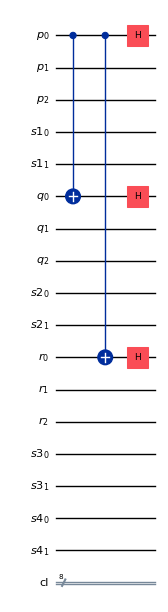

In [134]:
qc.cx(p[0], q[0])
qc.cx(p[0], r[0])
qc.h([p[0], q[0], r[0]])

qc.draw("mpl", scale = 0.5)

3) Den indre kode svarer til bitflip-fejlretningskoden, som også er gennemgået i en anden notebook. Denne kode anvendes på qubitsne i hver blok.

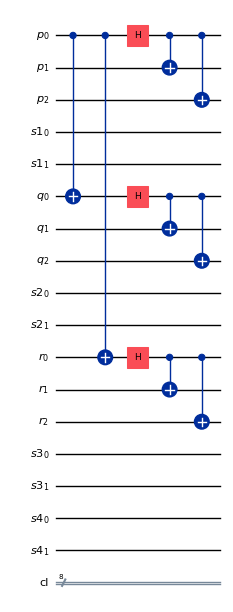

In [135]:
qc.barrier()
qc.cx(p[0], p[1])
qc.cx(p[0], p[2])
qc.cx(q[0], q[1])
qc.cx(q[0], q[2])
qc.cx(r[0], r[1])
qc.cx(r[0], r[2])
qc.draw("mpl", plot_barriers = 0, scale = 0.5)

4) Lad os starte med at introducere en tilfældig phase-flip-fejl hos en qubit i en af de tre blokke for at se, hvordan det håndteres.

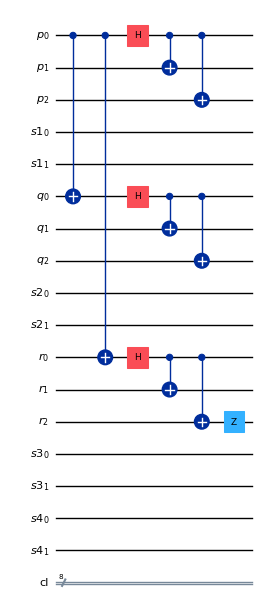

In [136]:
from random import randint
randomNumber = randint(0, 2)
if randomNumber == 0:
    qc.z(p[randint(0, 2)])
elif randomNumber == 1:
    qc.z(q[randint(0, 2)])
elif randomNumber == 2:
    qc.z(r[randint(0, 2)])

qc.draw("mpl", plot_barriers=0, scale = 0.5)

5) Relationer mellem Z- og CNOT-gates viser, at en phase-flip-fejl som den, der er vist efter den indre kodning på kredsløbet ovenfor, faktisk er det samme som en phase-flip-fejl på p<sub>0</sub>-, q<sub>0</sub>- eller r<sub>0</sub>-qubitten (afhængigt af i hvilken blok fejlen sker) FØR den indre kodning. Og det gælder uanset hvilken qubit i en blok, Z-fejlen sker ved. Ovenstående kredsløb er derfor det samme som følgende kredsløb.

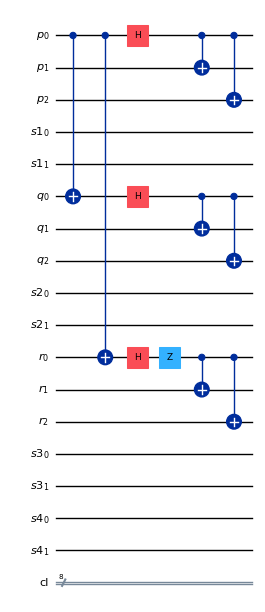

In [137]:
# Gentegn kredsløbet
qc.clear()
qc.cx(p[0], q[0])
qc.cx(p[0], r[0])
qc.h([p[0], q[0], r[0]])
qc.barrier()
if randomNumber == 0:
    qc.z(p[0])
elif randomNumber == 1:
    qc.z(q[0])
elif randomNumber == 2:
    qc.z(r[0])
qc.barrier()
qc.cx(p[0], p[1])
qc.cx(p[0], p[2])
qc.cx(q[0], q[1])
qc.cx(q[0], q[2])
qc.cx(r[0], r[1])
qc.cx(r[0], r[2])
qc.draw("mpl", plot_barriers=0, scale = 0.5)

6) Vi kan rette denne fejl ved at afkode den indre kode og så ellers bruge samme procedure som for phase-flip-fejlretningskredsløbet.

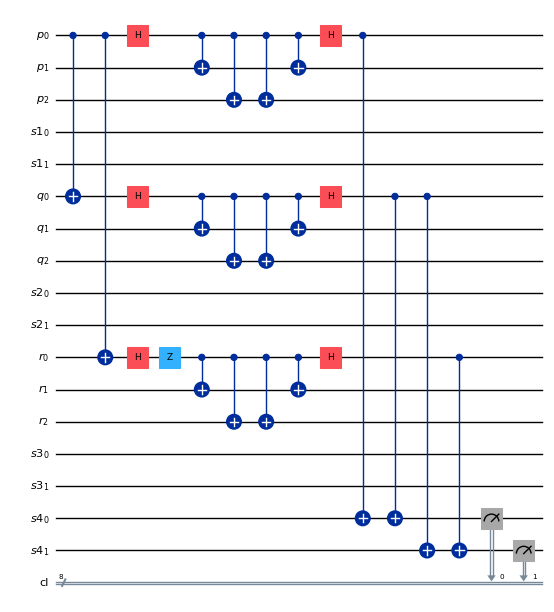

In [138]:
qc.barrier()
qc.cx(p[0], p[2])
qc.cx(p[0], p[1])
qc.cx(q[0], q[2])
qc.cx(q[0], q[1])
qc.cx(r[0], r[2])
qc.cx(r[0], r[1])
qc.barrier()
qc.h([p[0], q[0], r[0]])
qc.cx(p[0], s4[0])
qc.cx(q[0], s4[0])
qc.cx(q[0], s4[1])
qc.cx(r[0], s4[1])
qc.barrier()
qc.measure(s4[0], cl[0])
qc.measure(s4[1], cl[1])
qc.draw("mpl", plot_barriers=0, scale = 0.5)

7) Vi simulerer nu kredsløbet og retter fejlen.

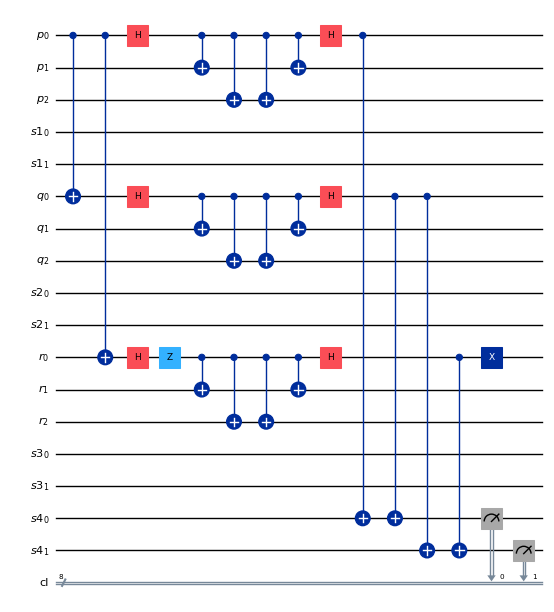

In [139]:
from qiskit.quantum_info import Pauli
from qiskit_aer.primitives import Estimator

estimator = Estimator()
job = estimator.run(2 * [qc], [Pauli("ZIIIIIIIIIIIIIIII"), Pauli("IZIIIIIIIIIIIIIII")], shots = 1)
syndrome = str(int(1 - job.result().values[0] / 2)) + str(int(1 - job.result().values[1] / 2))

if syndrome == "01":
    qc.x(p[0])
elif syndrome == "11":
    qc.x(q[0])
elif syndrome == "10":
    qc.x(r[0])

qc.draw("mpl", plot_barriers=0, scale = 0.5)

# Og vi har nu rettet en phase-flip-fejl. Men hvad med en bitflip-fejl?

1) Vi retter X-fejl inden for hver blok med samme procedure som for det "rene" bitflip-fejlretningskredsløb. Lad os se på et kredsløb, hvor der sker både en tilfældig Z- og X-fejl.

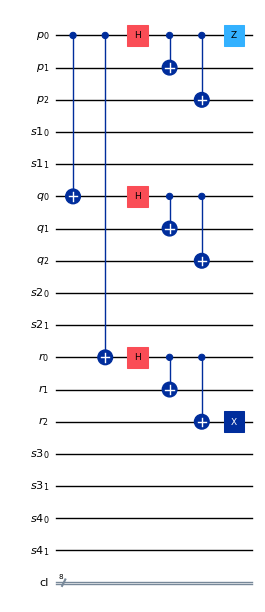

In [140]:
qc.clear()
qc.cx(p[0], q[0])
qc.cx(p[0], r[0])
qc.h([p[0], q[0], r[0]])
qc.barrier()
qc.cx(p[0], p[1])
qc.cx(p[0], p[2])
qc.cx(q[0], q[1])
qc.cx(q[0], q[2])
qc.cx(r[0], r[1])
qc.cx(r[0], r[2])

randomNumber1 = randint(0, 2)
randomNumber2 = randint(0, 2)
if randomNumber1 == 0:
    qc.z(p[randint(0, 2)])
elif randomNumber1 == 1:
    qc.z(q[randint(0, 2)])
elif randomNumber1 == 2:
    qc.z(r[randint(0, 2)])
if randomNumber2 == 0:
    qc.x(p[randint(0, 2)])
elif randomNumber2 == 1:
    qc.x(q[randint(0, 2)])
elif randomNumber2 == 2:
    qc.x(r[randint(0, 2)])

qc.draw("mpl", plot_barriers=0, scale = 0.5)

2) Det viser sig at være uden betydning i hvilken rækkefølge, vi retter fejlene. Lad os diagnosticere X-fejl først. Vi bliver nødt til at tjekke inden for hver blok.

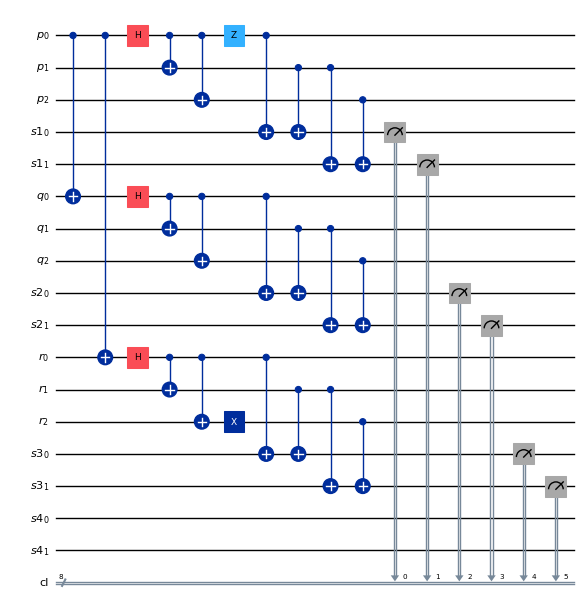

In [141]:
qc.barrier()
qc.cx(p[0], s1[0])
qc.cx(p[1], s1[0])
qc.cx(p[1], s1[1])
qc.cx(p[2], s1[1])
qc.cx(q[0], s2[0])
qc.cx(q[1], s2[0])
qc.cx(q[1], s2[1])
qc.cx(q[2], s2[1])
qc.cx(r[0], s3[0])
qc.cx(r[1], s3[0])
qc.cx(r[1], s3[1])
qc.cx(r[2], s3[1])
qc.barrier()
qc.measure(s1[0], cl[0])
qc.measure(s1[1], cl[1])
qc.measure(s2[0], cl[2])
qc.measure(s2[1], cl[3])
qc.measure(s3[0], cl[4])
qc.measure(s3[1], cl[5])
qc.draw("mpl", plot_barriers=0, scale = 0.5)

3) Vi simulerer nu kredsløbet og retter fejlen.

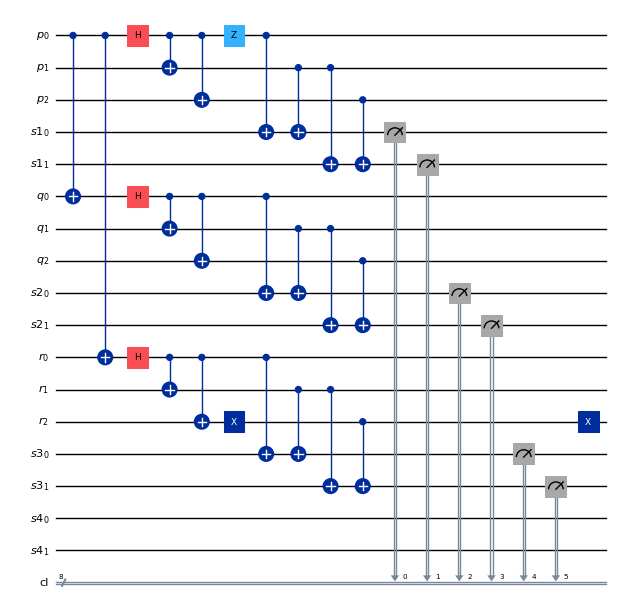

In [142]:
job = estimator.run(6 * [qc], [Pauli("IIZIIIIIIIIIIIIII"), Pauli("IIIZIIIIIIIIIIIII"),
                               Pauli("IIIIIIIZIIIIIIIII"), Pauli("IIIIIIIIZIIIIIIII"),
                               Pauli("IIIIIIIIIIIIZIIII"), Pauli("IIIIIIIIIIIIIZIII")], shots = 1)

syndrome1 = str(int(1 - job.result().values[4] / 2)) + str(int(1 - job.result().values[5] / 2))
syndrome2 = str(int(1 - job.result().values[2] / 2)) + str(int(1 - job.result().values[3] / 2))
syndrome3 = str(int(1 - job.result().values[0] / 2)) + str(int(1 - job.result().values[1] / 2))

qc.barrier()
if syndrome1 == "01":
    qc.x(p[0])
elif syndrome1 == "11":
    qc.x(p[1])
elif syndrome1 == "10":
    qc.x(p[2])

if syndrome2 == "01":
    qc.x(q[0])
elif syndrome2 == "11":
    qc.x(q[1])
elif syndrome2 == "10":
    qc.x(q[2])

if syndrome3 == "01":
    qc.x(r[0])
elif syndrome3 == "11":
    qc.x(r[1])
elif syndrome3 == "10":
    qc.x(r[2])

qc.draw("mpl", plot_barriers=0, scale = 0.5)

4) Vi identificerer nu phase-flip-fejlen som vist tidligere.

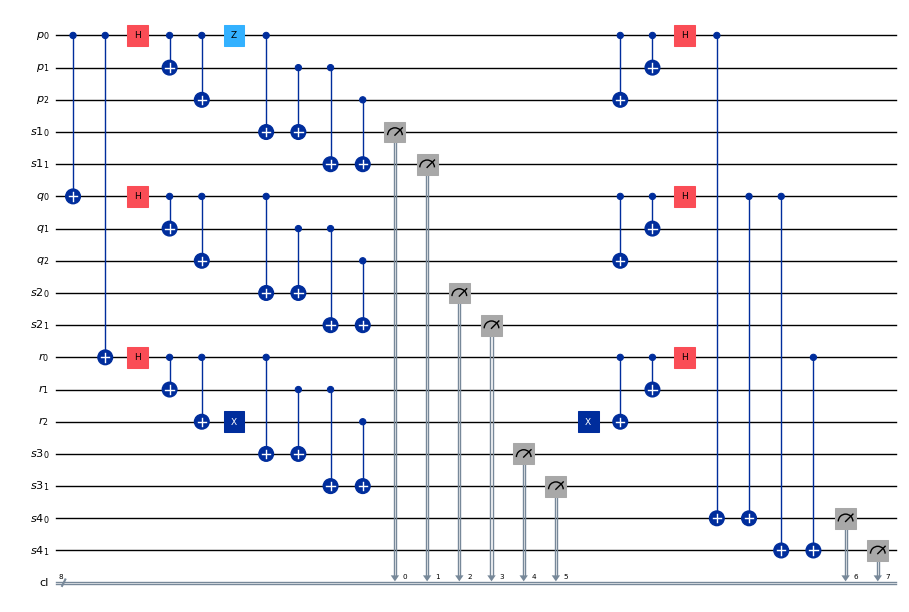

In [143]:
qc.barrier()
qc.cx(p[0], p[2])
qc.cx(p[0], p[1])
qc.cx(q[0], q[2])
qc.cx(q[0], q[1])
qc.cx(r[0], r[2])
qc.cx(r[0], r[1])
qc.barrier()
qc.h([p[0], q[0], r[0]])
qc.cx(p[0], s4[0])
qc.cx(q[0], s4[0])
qc.cx(q[0], s4[1])
qc.cx(r[0], s4[1])
qc.barrier()
qc.measure(s4[0], cl[6])
qc.measure(s4[1], cl[7])
qc.draw("mpl", plot_barriers=0, scale = 0.5, fold = 40)

5) Vi simulerer kredsløbet og retter fejlen.

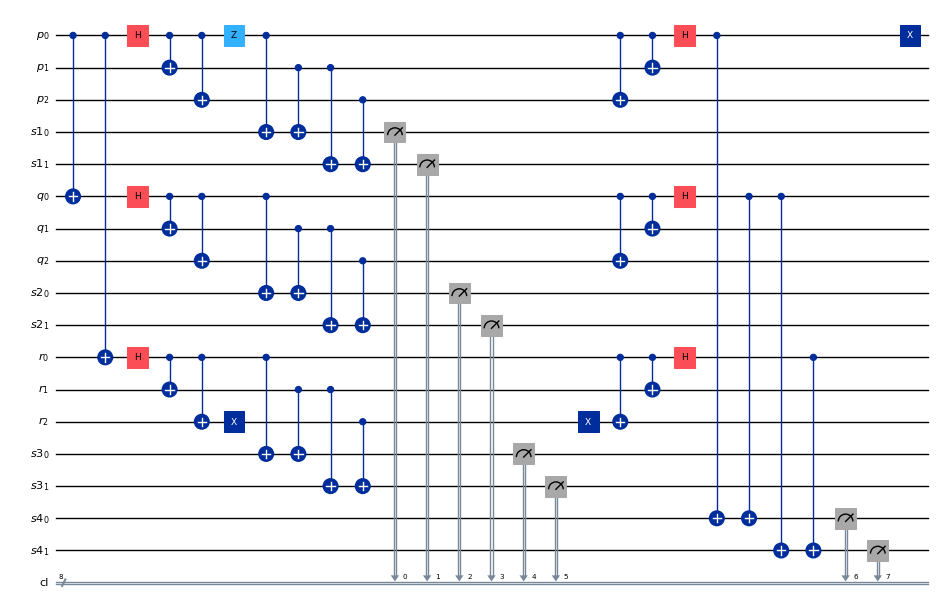

In [144]:
job = estimator.run(2 * [qc], [Pauli("ZIIIIIIIIIIIIIIII"), Pauli("IZIIIIIIIIIIIIIII")], shots = 1)
syndrome = str(int(1 - job.result().values[0] / 2)) + str(int(1 - job.result().values[1] / 2))

qc.barrier()
if syndrome == "01":
    qc.x(p[0])
elif syndrome == "11":
    qc.x(q[0])
elif syndrome == "10":
    qc.x(r[0])

qc.draw("mpl", plot_barriers=0, scale = 0.5, fold = 40)

Og vi har nu rettet både bitflip- og phase-flip-fejlene. Bemærk at vi bruger den sidste X-gate på første qubit i den blok, hvor Z-fejlen er sket, uanset om Z-fejlen så er sket på den qubit eller ej. Forklaringen er den samme som før: relationer mellem Z- og CNOT-gates gør, at det giver det samme.